In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import onnx
from PIL import Image
import onnxruntime
import numpy as np
import math
from torchvision import transforms

epochs = 8
batch_size = 64
learning_rate = 0.001
momentum = 0.9
print_interval = 200
accuracy_list = list()
device = torch.device('cpu')

mnist_trainset = torchvision.datasets.MNIST(root='~/data', train=True, download=True,
            transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor(),
         transforms.Normalize(mean=[0.5], std=[0.5])]))
mnist_testset = torchvision.datasets.MNIST(root='~/data', train=False, download=True, 
        transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor(),
         transforms.Normalize(mean=[0.5], std=[0.5])]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset,
                                            [int(0.2 * len(mnist_testset)), int(0.8 * len(mnist_testset))])

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(mnist_valset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

In [2]:
# visualize data
labels = list()
for i in range(0, 8000):
    img = transforms.ToPILImage(mode='L')(mnist_testset[i][0])
    img.save('./testCNN/'+str(i)+".png")
    labels.append(mnist_testset[i][1])
    
with open("labele.txt","w") as f:
    for item in labels:
        f.write(str(item))
        f.write(' ')

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 150)
        self.fc2 = nn.Linear(150,100)
        self.fc3 = nn.Linear(100,10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
network = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
network.to(device)
pytorch_total_params = sum(p.numel() for p in network.parameters())

In [5]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % print_interval == 0: #ispisujemo samo neke da ne bude nakracan ispis
              print('Train| Epoch {}| {}/{} ({:.0f}%)| Loss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

In [6]:
def valid(epoch):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(valid_loader.dataset)
    print('Valid| Epoch {}| Avg. loss: {:.4f}| Accuracy: {}/{} ({:.2f}%)'.format(epoch, 
    test_loss, correct, len(valid_loader.dataset),
    100.*correct / len(valid_loader.dataset)))
    accuracy_list.append(100.*correct / len(valid_loader.dataset))

In [7]:
def test():
    ti = time.time()
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('Tests| Avg. loss: {:.4f}| Accuracy: {}/{} ({:.2f}%)'.format(test_loss, correct,
            len(test_loader.dataset),100.*correct / len(test_loader.dataset)))
    print("Testing time for all images: {}".format(time.time() -ti))

In [8]:
print('Training and validating network with {} parameters'.format(pytorch_total_params))
valid(0)
print(" ")
for epoch in range(1, epochs + 1):
    time0 = time.time()
    train(epoch)
    valid(epoch)
    print("Running time for Epoch {}: {}\n".format(epoch, time.time() - time0))
    
print("Testing network with {} parameters".format(pytorch_total_params))
test()

Training and validating network with 69540 parameters


/home/jelena/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Valid| Epoch 0| Avg. loss: 2.3030| Accuracy: 207/2000 (10.35%)
 
Train| Epoch 1| 0/60000 (0%)| Loss: 2.307986
Train| Epoch 1| 12800/60000 (21%)| Loss: 2.281200
Train| Epoch 1| 25600/60000 (43%)| Loss: 2.227972
Train| Epoch 1| 38400/60000 (64%)| Loss: 1.713558
Train| Epoch 1| 51200/60000 (85%)| Loss: 0.531859
Valid| Epoch 1| Avg. loss: 0.4218| Accuracy: 1741/2000 (87.05%)
Running time for Epoch 1: 19.612364292144775

Train| Epoch 2| 0/60000 (0%)| Loss: 0.381287
Train| Epoch 2| 12800/60000 (21%)| Loss: 0.536086
Train| Epoch 2| 25600/60000 (43%)| Loss: 0.139064
Train| Epoch 2| 38400/60000 (64%)| Loss: 0.142241
Train| Epoch 2| 51200/60000 (85%)| Loss: 0.215018
Valid| Epoch 2| Avg. loss: 0.1752| Accuracy: 1888/2000 (94.40%)
Running time for Epoch 2: 18.866254568099976

Train| Epoch 3| 0/60000 (0%)| Loss: 0.135812
Train| Epoch 3| 12800/60000 (21%)| Loss: 0.099776
Train| Epoch 3| 25600/60000 (43%)| Loss: 0.156867
Train| Epoch 3| 38400/60000 (64%)| Loss: 0.168104
Train| Epoch 3| 51200/60000 (8

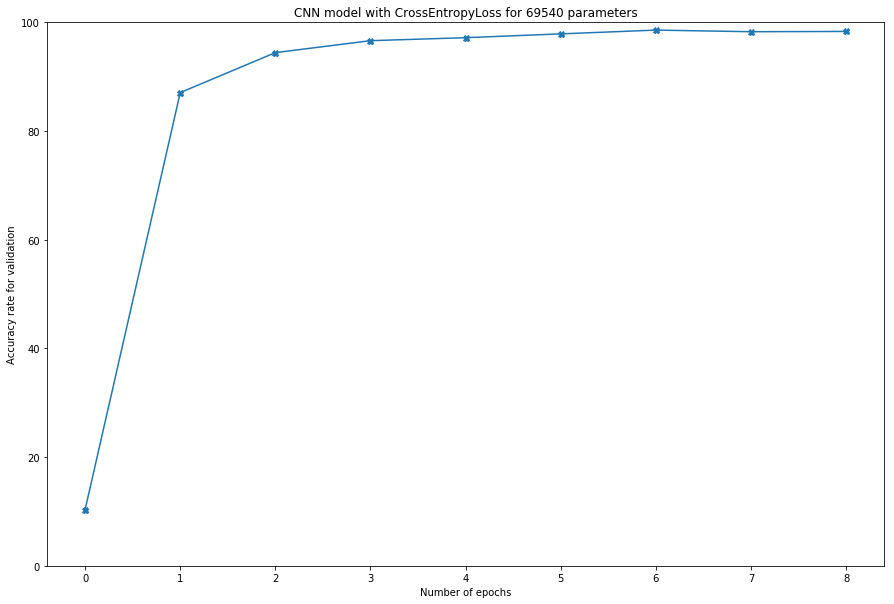

In [9]:
plt.figure(figsize =(15,10))
plt.plot(range(epochs + 1), accuracy_list, '-X')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy rate for validation")
plt.ylim(0,100)
plt.title("CNN model with CrossEntropyLoss for {} parameters".format(pytorch_total_params))
plt.show()

In [10]:
# set the model to inference mode
network.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [11]:
# Input to the model
x = torch.randn(1, 1, 28, 28, requires_grad=False)

# Export the model
torch.onnx.export(network,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "CNN_69540.onnx", # where to save the model(can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'] # the model's output names
                  )


In [12]:
ort_session = onnxruntime.InferenceSession("CNN_69540.onnx")
torch_out = network(x)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)